## Data Loading and Initial Exploration

Understanding your data is crucial before building any model. This step helps identify data quality issues and informs feature engineering decisions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

In [2]:
# Basic info
print(ratings.info())
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


In [3]:
# Display first few rows
print(ratings.head())
print(movies.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [4]:
# Basic statistics
print(ratings.describe())
print(movies.describe())

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000


In [5]:
# Check for missing values
print(ratings.isnull().sum())
print(movies.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


## Data Cleaning and Preprocessing

Clean data leads to better models. We handle missing values, convert data types, and prepare the dataset for modeling.

In [6]:
# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [7]:
# Extract year from movie title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [8]:
# Split genres into lists
movies['genres'] = movies['genres'].str.split('|')

In [9]:
# Create genre indicators (for content-based filtering)
genres = set()
for g_list in movies['genres']:
    genres.update(g_list)
    
for genre in genres:
    movies[genre] = movies['genres'].apply(lambda x: 1 if genre in x else 0)

In [10]:
# Remove movies with very few ratings
movie_rating_counts = ratings['movieId'].value_counts()
popular_movies = movie_rating_counts[movie_rating_counts >= 10].index
ratings = ratings[ratings['movieId'].isin(popular_movies)]

## Exploratory Data Analysis (EDA)

EDA reveals patterns, relationships, and insights that guide model selection and feature engineering.

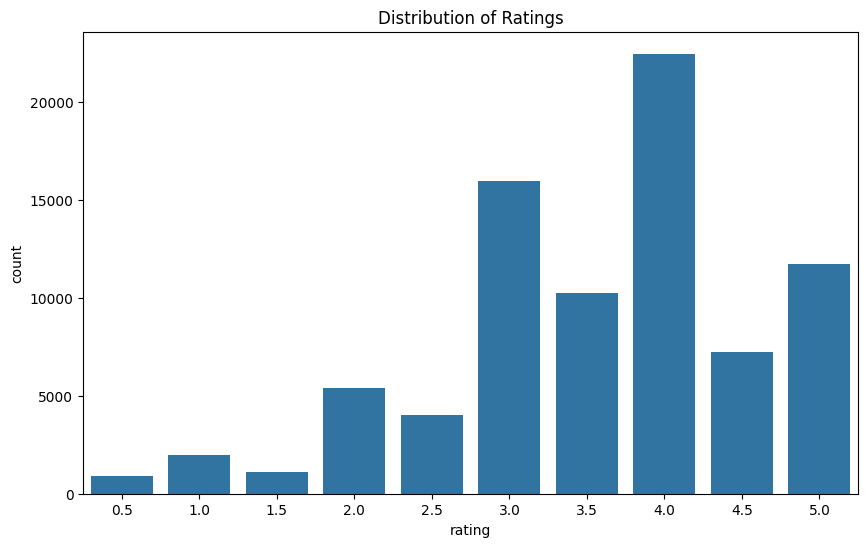

In [11]:
# Rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

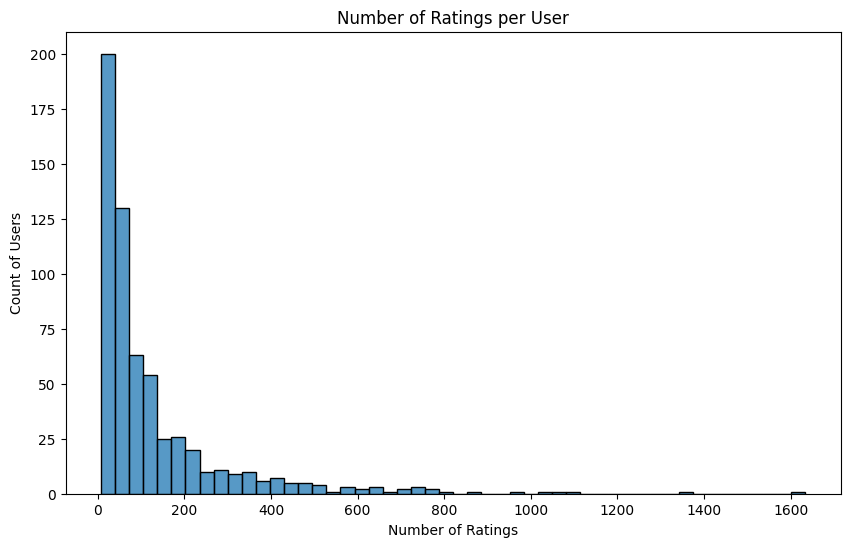

In [12]:
# Ratings per user
user_rating_counts = ratings['userId'].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_rating_counts, bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

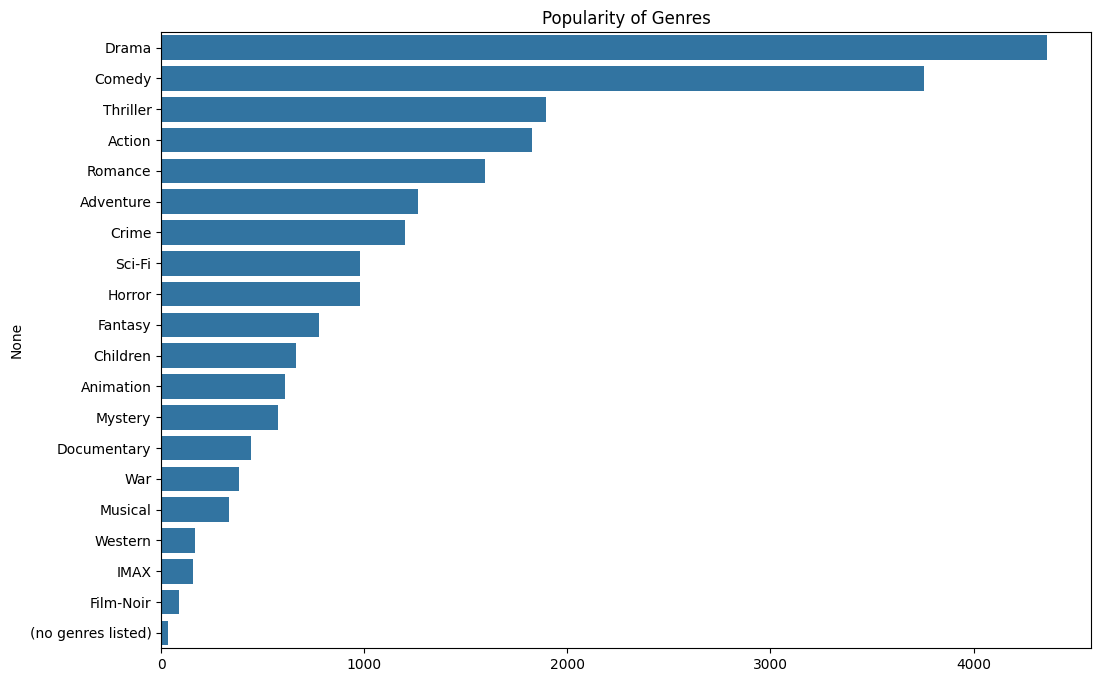

In [13]:
# Top genres
genre_counts = movies[list(genres)].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Popularity of Genres')
plt.show()

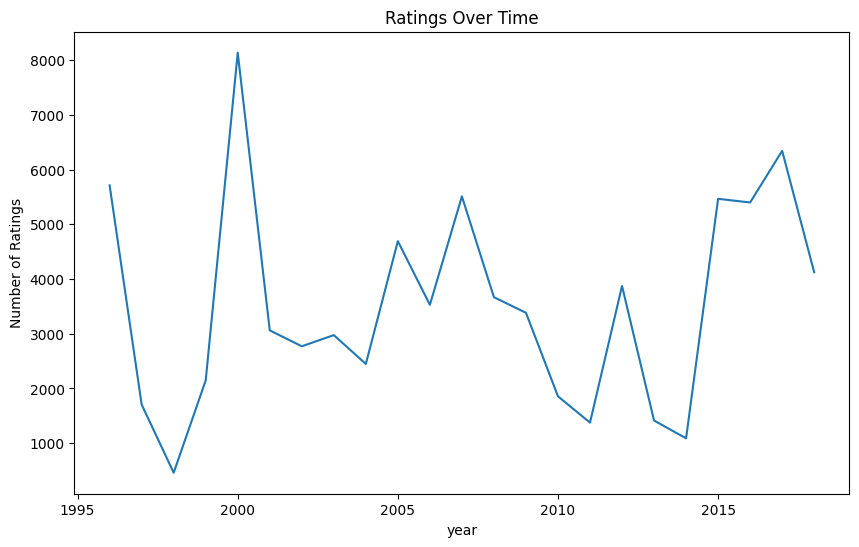

In [14]:
# Temporal analysis
ratings['year'] = ratings['timestamp'].dt.year
yearly_ratings = ratings.groupby('year').size()
plt.figure(figsize=(10, 6))
yearly_ratings.plot()
plt.title('Ratings Over Time')
plt.ylabel('Number of Ratings')
plt.show()

## Feature Engineering

Transform raw data into features that better represent the underlying problem to predictive models.

In [ ]:
# 1. For collaborative filtering

# Create user-movie matrix
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

In [16]:
# Normalize ratings by subtracting user mean (centering)
user_mean_ratings = ratings.groupby('userId')['rating'].mean()
ratings['normalized_rating'] = ratings.apply(
    lambda row: row['rating'] - user_mean_ratings[row['userId']], axis=1)

In [17]:
# 2. For content-based filtering

# Create TF-IDF matrix of movie genres
from sklearn.feature_extraction.text import TfidfVectorizer

movies['genres_text'] = movies['genres'].apply(lambda x: ' '.join(x))
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split(' '))
tfidf_matrix = tfidf.fit_transform(movies['genres_text'])

/Users/in22417145/PycharmProjects/data-science-projects/dsvenv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Model Building - Collaborative Filtering

Collaborative filtering is effective when we have sufficient user-item interaction data.

In [18]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load data into Surprise format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [19]:
# Split data
trainset, testset = train_test_split(data, test_size=0.25)

In [20]:
# User-based collaborative filtering
sim_options = {
    'name': 'cosine',
    'user_based': True
}

user_cf = KNNBasic(sim_options=sim_options)
user_cf.fit(trainset)
user_predictions = user_cf.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [21]:
# Evaluate
accuracy.rmse(user_predictions)

RMSE: 0.9460


0.9459886792563635

In [22]:
# Item-based collaborative filtering
sim_options['user_based'] = False
item_cf = KNNBasic(sim_options=sim_options)
item_cf.fit(trainset)
item_predictions = item_cf.test(testset)
accuracy.rmse(item_predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9464


0.9464093589705777

## Model Building - Content-Based Filtering

Content-based filtering works well for cold-start problems (new users or items).

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between movies
content_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

def content_based_recommendations(movie_id, n=5):
    # Get index of movie
    idx = movies.index[movies['movieId'] == movie_id].tolist()[0]
    
    # Get similarity scores
    sim_scores = list(enumerate(content_similarity[idx]))
    
    # Sort by similarity
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top n similar movies (excluding itself)
    sim_scores = sim_scores[1:n+1]
    
    # Get movie indices and similarity scores
    movie_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]
    
    # Return recommendations
    return movies.iloc[movie_indices][['movieId', 'title', 'genres']], scores

## Model Evaluation and Hyperparameter Tuning

Ensures our model generalizes well to unseen data and performs optimally.

In [24]:
from surprise.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'k': [20, 30, 40],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False]
    }
}

In [25]:
# Grid search
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Comput

In [26]:
# Best RMSE score
print(gs.best_score['rmse'])

0.9330075640955746


In [27]:
# Best parameters
print(gs.best_params['rmse'])

{'k': 40, 'sim_options': {'name': 'pearson', 'user_based': False}}


In [28]:
# Train final model with best parameters
final_model = gs.best_estimator['rmse']
final_model.fit(data.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [31]:
from surprise import dump

# Save the model to disk
dump.dump('models/final_model.pkl', algo=final_model)

In [32]:
# Also save the movies DataFrame for reference during deployment
movies.to_pickle('models/movies.pkl') 

## Building a Hybrid Recommender

Hybrid approaches often outperform single-method recommenders by combining their strengths.

In [29]:
def hybrid_recommendation(user_id, movie_id=None, n=5):
    if movie_id:
        # Content-based recommendations
        cb_recs, _ = content_based_recommendations(movie_id, n*2)
        
        # Get predicted ratings for these movies from collaborative model
        cb_recs['predicted_rating'] = cb_recs['movieId'].apply(
            lambda x: final_model.predict(user_id, x).est)
        
        # Sort by predicted rating
        return cb_recs.sort_values('predicted_rating', ascending=False).head(n)
    
    else:
        # Get all movies user hasn't rated
        rated_movies = ratings[ratings['userId'] == user_id]['movieId']
        all_movies = set(ratings['movieId'].unique())
        unrated_movies = all_movies - set(rated_movies)
        
        # Get predicted ratings
        predictions = []
        for movie in unrated_movies:
            pred = final_model.predict(user_id, movie)
            predictions.append((movie, pred.est))
        
        # Sort and return top n
        predictions.sort(key=lambda x: x[1], reverse=True)
        top_movies = [x[0] for x in predictions[:n]]
        
        return movies[movies['movieId'].isin(top_movies)]

## Model Deployment using Flask

Deployment makes your model accessible and demonstrates production readiness.

code: movie_app.py